In [30]:
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Populating the interactive namespace from numpy and matplotlib


C:\Users\KyleLam\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['long']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [21]:
zcode=pd.read_csv('uszips.csv')
zcode["state_id"].unique()
zcode = zcode.drop(zcode.index[zcode['state_id'] != 'DC'])

In [22]:
zcode[zcode['military']!=False].size
zcode = zcode.drop(['zcta','parent_zcta','population','density','county_fips','all_county_weights','imprecise','military','timezone'], axis=1)
zcode.head()

,zip,lat,lng,city,state_id,state_name,county_name
6213,20001,38.9108,-77.0178,Washington,DC,District of Columbia,District of Columbia
6214,20002,38.9051,-76.9843,Washington,DC,District of Columbia,District of Columbia
6215,20003,38.8812,-76.9906,Washington,DC,District of Columbia,District of Columbia
6216,20004,38.8949,-77.0287,Washington,DC,District of Columbia,District of Columbia
6217,20005,38.9047,-77.0315,Washington,DC,District of Columbia,District of Columbia


In [26]:
zcode = zcode[zcode['city']=='Washington']

In [27]:
zcode["city"].unique()

array(['Washington'], dtype=object)

In [29]:
latitude = 38.88
longitude = -77.0
map_wash = folium.Map(location=[latitude, longitude], zoom_start=10)

for lati, long, postcode, city in zip(zcode['lat'], zcode['lng'], zcode['zip'], zcode['city']):
    label = '{}, {}'.format(postcode, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lati, long],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wash)  
    
map_wash

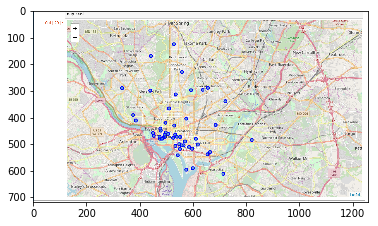

In [32]:
img=mpimg.imread('wash map.png')
imgplot = plt.imshow(img)
plt.show()

# Because Github cannot show a map picture
# So I show the result using plt

In [33]:
CLIENT_ID = '3NY3SEOKJTUG0HJDQAE0EV0PV3FNDZ3DX40VQCYAVY153TCD'
CLIENT_SECRET = '5MREBCBTVWLGEMJZUX43IRJHYOB3CHU4VDSIZQHW5BHAKXNC'
VERSION = '20180605'

In [34]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cff8cbc4c1f6753b8a22aff'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Capitol Hill',
  'headerFullLocation': 'Capitol Hill, Washington',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 50,
  'suggestedBounds': {'ne': {'lat': 38.884500004500005,
    'lng': -76.99423016057727},
   'sw': {'lat': 38.8754999955, 'lng': -77.00576983942273}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae04a3cf964a5207d7e21e3',
       'name': 'Cornercopia',
       'location': {'address': '1000 3rd St SE',
        'crossStreet': 'at K St.',
        'lat': 38.87833887482248,
        'lng': -77.0020996885

In [35]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Cornercopia,Deli / Bodega,38.878339,-77.002100
1,Biker Barre,Gym / Fitness Center,38.880068,-76.995964
2,Canal Park,Park,38.877904,-77.003260
3,Capitol Hill Arts Workshop,Art Gallery,38.881452,-76.996350
4,Rose's Luxury,New American Restaurant,38.880660,-76.995175


In [38]:
nearby_venues['categories'].unique()

array(['Deli / Bodega', 'Gym / Fitness Center', 'Park', 'Art Gallery',
       'New American Restaurant', 'Grocery Store', 'Donut Shop',
       'Restaurant', 'Wine Shop', 'Food Truck', 'Pizza Place',
       'Greek Restaurant', 'Café', 'Playground', 'Supermarket', 'Plaza',
       'Eastern European Restaurant', 'Coffee Shop', 'Beer Garden',
       'Liquor Store', 'Italian Restaurant', 'Burger Joint',
       'Sushi Restaurant', 'Bakery', 'Steakhouse', 'Pet Store',
       'American Restaurant', 'Bar', 'Hotel', 'Bank', 'Dog Run',
       'Furniture / Home Store', 'Martial Arts Dojo',
       'Bike Rental / Bike Share', 'Sandwich Place', 'Pharmacy',
       "Women's Store", 'Mobile Phone Shop', 'Farmers Market',
       'Cycle Studio'], dtype=object)

In [39]:
def getNearbyVenues(postalcodes, latitudes, longitudes, radius=500, min_venues=0):
    
    venues_list=[]
    for zipcode, lat, lng in zip(postalcodes, latitudes, longitudes):
        
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        print("number of venues for zipcode {} is : {} venues.".format(zipcode,len(results)))
        
        
        for v in results :
                            venues_list.append([(
                                                zipcode, 
                                                lat, 
                                                lng, 
                                                v['venue']['name'], 
                                                v['venue']['location']['lat'], 
                                                v['venue']['location']['lng'],  
                                                v['venue']['categories'][0]['name'])])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PC Latitude', 
                  'PC Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
dal_venues = getNearbyVenues(postalcodes=zcode['zip'],
                            latitudes=zcode['lat'],
                            longitudes=zcode['lng'],
                            min_venues=0)

number of venues for zipcode 20001 is : 33 venues.
number of venues for zipcode 20002 is : 12 venues.
number of venues for zipcode 20003 is : 62 venues.
number of venues for zipcode 20004 is : 100 venues.
number of venues for zipcode 20005 is : 100 venues.
number of venues for zipcode 20006 is : 88 venues.
number of venues for zipcode 20007 is : 7 venues.
number of venues for zipcode 20008 is : 37 venues.
number of venues for zipcode 20009 is : 71 venues.
number of venues for zipcode 20010 is : 37 venues.
number of venues for zipcode 20011 is : 13 venues.
number of venues for zipcode 20012 is : 6 venues.
number of venues for zipcode 20015 is : 2 venues.
number of venues for zipcode 20016 is : 18 venues.
number of venues for zipcode 20017 is : 11 venues.
number of venues for zipcode 20018 is : 18 venues.
number of venues for zipcode 20019 is : 7 venues.
number of venues for zipcode 20020 is : 0 venues.
number of venues for zipcode 20024 is : 36 venues.
number of venues for zipcode 20032

In [43]:
dal_venues['Venue Category'].unique()

array(['Coffee Shop', 'Beer Garden', 'Wine Shop', 'Neighborhood',
       'Cocktail Bar', 'Spanish Restaurant', 'Thai Restaurant',
       'BBQ Joint', 'Dive Bar', 'Hot Dog Joint', 'Korean Restaurant',
       'Café', 'Wine Bar', 'Ice Cream Shop', 'Bar',
       'Middle Eastern Restaurant', 'Grocery Store', 'Pet Store',
       'Dog Run', 'Market', 'Liquor Store', 'Gym / Fitness Center',
       'Donut Shop', 'Convenience Store', 'Pizza Place', 'Yoga Studio',
       'Bus Stop', 'Park', 'Sandwich Place', 'Indie Theater', 'Bus Line',
       'Diner', 'Gym', 'Moving Target', 'New American Restaurant',
       'Pharmacy', 'Food & Drink Shop', 'Spa', 'Greek Restaurant',
       'Chinese Restaurant', 'Restaurant', 'American Restaurant', 'Plaza',
       'Eastern European Restaurant', 'Italian Restaurant',
       'Asian Restaurant', 'Gay Bar', 'Belgian Restaurant', 'Supermarket',
       'Art Gallery', 'Bakery', 'Mediterranean Restaurant', 'Steakhouse',
       'Sushi Restaurant', 'Seafood Restaurant', '

In [46]:
dal_venues_onehot = pd.get_dummies(dal_venues[['Venue Category']], prefix="", prefix_sep="")
dal_venues_onehot['PostalCode'] = dal_venues['PostalCode'] 
fixed_columns = [dal_venues_onehot.columns[-1]] + list(dal_venues_onehot.columns[:-1])
dal_venues_onehot = dal_venues_onehot[fixed_columns]

In [47]:
dal_venues_grouped = dal_venues_onehot.groupby('PostalCode').mean().reset_index()
dal_venues_grouped.head()

,PostalCode,Accessories Store,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beer Bar,Beer Garden,Belgian Restaurant,Bike Rental / Bike Share,Boat or Ferry,Bookstore,Botanical Garden,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Capitol Building,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Chocolate Shop,Christmas Market,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Quad,College Residence Hall,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Courthouse,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,National Park,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,River,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Trail,Train Station,Tree,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Xinjiang Restaurant,Yoga Studio
0,20001,0.0,0.000000,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.0,0.060606,0.0,0.000000,0.0,0.030303,0.0,0.00,0.030303,0.000000,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.030303,0.0,0.0,0.030303,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.030303,0.030303,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.030303,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.030303,0.030303,0.030303,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.000000,0

In [49]:
num_top_venues = 5

for area in dal_venues_grouped['PostalCode']:
    print("----- {} -----".format(area))
    temp = dal_venues_grouped[dal_venues_grouped['PostalCode'] == area].T.reset_index()
    temp.columns = ['venue cateory','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----- 20001 -----
     venue cateory  freq
0     Liquor Store  0.09
1  Thai Restaurant  0.09
2        BBQ Joint  0.06
3      Yoga Studio  0.03
4      Pizza Place  0.03


----- 20002 -----
   venue cateory  freq
0          Diner  0.08
1  Moving Target  0.08
2            Gym  0.08
3       Pharmacy  0.08
4            Bar  0.08


----- 20003 -----
          venue cateory  freq
0           Pizza Place  0.06
1  Gym / Fitness Center  0.05
2                   Spa  0.05
3                   Bar  0.03
4    Italian Restaurant  0.03


----- 20004 -----
    venue cateory  freq
0  History Museum  0.06
1           Hotel  0.05
2  Science Museum  0.05
3     Coffee Shop  0.04
4          Bakery  0.04


----- 20005 -----
         venue cateory  freq
0                Hotel  0.11
1          Coffee Shop  0.06
2            Hotel Bar  0.06
3  American Restaurant  0.04
4   Salon / Barbershop  0.04


----- 20006 -----
         venue cateory  freq
0          Coffee Shop  0.11
1       Sandwich Place  0.10
2        

       venue cateory  freq
0    Harbor / Marina  0.18
1           Heliport  0.09
2  Indian Restaurant  0.09
3            Gay Bar  0.09
4     Soccer Stadium  0.09




In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

postalcode_area_venues_sorted = pd.DataFrame(columns=columns)
postalcode_area_venues_sorted['PostalCode'] = dal_venues_grouped['PostalCode']

for ind in np.arange(dal_venues_grouped.shape[0]):
    postalcode_area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dal_venues_grouped.iloc[ind, :], num_top_venues)

In [52]:
kclusters = 5
dal_venues_grouped_clustering = dal_venues_grouped.drop('PostalCode', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dal_venues_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1])

In [53]:
postalcode_area_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
dal_merged = zcode
dal_merged = dal_merged.join(postalcode_area_venues_sorted.set_index('PostalCode'), on='zip', how='inner')
dal_merged.head()

,zip,lat,lng,city,state_id,state_name,county_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6213,20001,38.9108,-77.0178,Washington,DC,District of Columbia,District of Columbia,0,Thai Restaurant,Liquor Store,BBQ Joint,Yoga Studio,Dog Run,Café,Cocktail Bar,Coffee Shop,Convenience Store,Pizza Place
6214,20002,38.9051,-76.9843,Washington,DC,District of Columbia,District of Columbia,0,Indie Theater,Sandwich Place,Diner,Bus Line,New American Restaurant,Food & Drink Shop,Gym,Liquor Store,Bar,Moving Target
6215,20003,38.8812,-76.9906,Washington,DC,District of Columbia,District of Columbia,0,Pizza Place,Spa,Gym / Fitness Center,Mobile Phone Shop,Italian Restaurant,Sandwich Place,Chinese Restaurant,Bar,Bakery,Coffee Shop
6216,20004,38.8949,-77.0287,Washington,DC,District of Columbia,District of Columbia,0,History Museum,Hotel,Science Museum,Coffee Shop,Bakery,American Restaurant,Sandwich Place,Plaza,Exhibit,Steakhouse
6217,20005,38.9047,-77.0315,Washington,DC,District of Columbia,District of Columbia,0,Hotel,Hotel Bar,Coffee Shop,American Restaurant,Food Truck,Salon / Barbershop,Latin American Restaurant,Deli / Bodega,Sandwich Place,Sushi Restaurant


In [54]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lati, long, city, poi, cluster in zip(dal_merged['lat'], dal_merged['lng'], dal_merged['city'], dal_merged['zip'], dal_merged['Cluster Labels']):
    label = folium.Popup(str(city) + ', ' + str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lati, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.99).add_to(map_clusters)
       
map_clusters

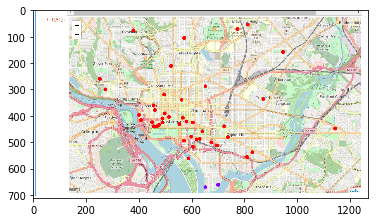

In [55]:
img=mpimg.imread('clusters.png')
imgplot = plt.imshow(img)
plt.show()

# Because Github cannot show a map picture
# So I show the result using plt

In [57]:
dal_merged.loc[dal_merged['Cluster Labels'] == 0, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6213,20001,District of Columbia,0,Liquor Store,BBQ Joint,Yoga Studio,Dog Run,Café,Cocktail Bar,Coffee Shop,Convenience Store,Pizza Place
6214,20002,District of Columbia,0,Sandwich Place,Diner,Bus Line,New American Restaurant,Food & Drink Shop,Gym,Liquor Store,Bar,Moving Target
6215,20003,District of Columbia,0,Spa,Gym / Fitness Center,Mobile Phone Shop,Italian Restaurant,Sandwich Place,Chinese Restaurant,Bar,Bakery,Coffee Shop
6216,20004,District of Columbia,0,Hotel,Science Museum,Coffee Shop,Bakery,American Restaurant,Sandwich Place,Plaza,Exhibit,Steakhouse
6217,20005,District of Columbia,0,Hotel Bar,Coffee Shop,American Restaurant,Food Truck,Salon / Barbershop,Latin American Restaurant,Deli / Bodega,Sandwich Place,Sushi Restaurant
6218,20006,District of Columbia,0,Sandwich Place,Hotel,Café,American Restaurant,History Museum,Park,Bakery,Mexican Restaurant,Indian Restaurant
6219,20007,District of Columbia,0,Fast Food Restaurant,Bus Station,Park,Dog Run,Bagel Shop,Food Truck,Food & Drink Shop,Food Court,Fountain
6220,20008,District of Columbia,0,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Supplement Shop,Steakhouse,Sports Bar,Gift Shop,Liquor Store,Café
6221,20009,District of Columbia,0,Pizza Place,Cosmetics Shop,Jazz Club,Restaurant,Taco Place,Diner,Ethiopian Restaurant,Bakery,Latin American Restaurant
6222,20010,District of Columbia,0,Vietnamese Restaurant,Bakery,Pizza Place,Asian Restaurant,Yoga Studio,Caribbean Restaurant,Breakfast Spot,Mediterranean Restaurant,Soccer Field


In [58]:
dal_merged.loc[dal_merged['Cluster Labels'] == 1, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6295,20319,District of Columbia,1,Boat or Ferry,Filipino Restaurant,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Food Truck
6311,20593,District of Columbia,1,River,Sporting Goods Shop,Brewery,Heliport,Gay Bar,Boat or Ferry,Pizza Place,Soccer Stadium,Indian Restaurant


In [59]:
dal_merged.loc[dal_merged['Cluster Labels'] == 2, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6224,20012,District of Columbia,2,Dive Bar,Bus Station,Gym,Fast Food Restaurant,Yoga Studio,Fountain,Food Court,Food Truck,Fried Chicken Joint


In [60]:
dal_merged.loc[dal_merged['Cluster Labels'] == 3, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6225,20015,District of Columbia,3,Farmers Market,Yoga Studio,Filipino Restaurant,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain


In [61]:
dal_merged.loc[dal_merged['Cluster Labels'] == 4, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6294,20317,District of Columbia,4,Deli / Bodega,Golf Course,Gastropub,Gas Station,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant


In [67]:
kclusters = 10
dal_venues_grouped_clustering = dal_venues_grouped.drop('PostalCode', 1)
kmeans_k10 = KMeans(n_clusters=kclusters, random_state=0).fit(dal_venues_grouped_clustering)
kmeans_k10.labels_

array([1, 1, 1, 1, 1, 7, 6, 1, 1, 1, 1, 8, 2, 7, 0, 1, 1, 1, 9, 1, 1, 1,
       7, 4, 7, 7, 4, 4, 4, 1, 7, 7, 1, 3, 5, 1, 7, 7, 7, 7, 1, 7, 1, 1,
       7, 4, 4, 4, 1, 1])

In [68]:
kmeans_k10.labels_[4]

1

In [69]:
a=kmeans_k10.labels_
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0: 1, 1: 23, 2: 1, 3: 1, 4: 7, 5: 1, 6: 1, 7: 13, 8: 1, 9: 1}

In [70]:
kclusters = 20
dal_venues_grouped_clustering = dal_venues_grouped.drop('PostalCode', 1)
kmeans_k20 = KMeans(n_clusters=kclusters, random_state=0).fit(dal_venues_grouped_clustering)
unique, counts = np.unique(kmeans_k20.labels_, return_counts=True)

In [71]:
dict(zip(unique, counts))

{0: 1,
 1: 1,
 2: 1,
 3: 16,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 9,
 9: 1,
 10: 1,
 11: 4,
 12: 1,
 13: 1,
 14: 3,
 15: 2,
 16: 2,
 17: 1,
 18: 1,
 19: 1}

In [72]:
unique, counts = np.unique(kmeans_k20.labels_, return_counts=True)

In [73]:
dal_venues_grouped_clustering = dal_venues_grouped.drop('PostalCode', 1)

for i in ([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]):

    kclusters = i

    kmeans_ki = KMeans(n_clusters=kclusters, random_state=0).fit(dal_venues_grouped_clustering)

    unique, counts = np.unique(kmeans_ki.labels_, return_counts=True)
    print("# of points per cluster for {} clusters: ".format(i))
    print(dict(zip(unique, counts)))

# of points per cluster for 2 clusters: 
{0: 49, 1: 1}
# of points per cluster for 3 clusters: 
{0: 1, 1: 1, 2: 48}
# of points per cluster for 4 clusters: 
{0: 5, 1: 43, 2: 1, 3: 1}
# of points per cluster for 5 clusters: 
{0: 45, 1: 2, 2: 1, 3: 1, 4: 1}
# of points per cluster for 6 clusters: 
{0: 1, 1: 21, 2: 1, 3: 25, 4: 1, 5: 1}
# of points per cluster for 7 clusters: 
{0: 1, 1: 25, 2: 20, 3: 1, 4: 1, 5: 1, 6: 1}
# of points per cluster for 8 clusters: 
{0: 7, 1: 1, 2: 1, 3: 1, 4: 1, 5: 24, 6: 1, 7: 14}
# of points per cluster for 9 clusters: 
{0: 6, 1: 27, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 11}
# of points per cluster for 10 clusters: 
{0: 1, 1: 23, 2: 1, 3: 1, 4: 7, 5: 1, 6: 1, 7: 13, 8: 1, 9: 1}
# of points per cluster for 11 clusters: 
{0: 13, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 14, 9: 6, 10: 10}
# of points per cluster for 12 clusters: 
{0: 6, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 9, 7: 6, 8: 1, 9: 1, 10: 1, 11: 21}
# of points per cluster for 13 clusters: 
{0: 1, 1: 

In [74]:
kclusters=7
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lati, long, city, poi, cluster in zip(dal_merged['lat'], dal_merged['lng'], dal_merged['city'], dal_merged['zip'], dal_merged['Cluster Labels']):
    label = folium.Popup(str(city) + ', ' + str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lati, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.99).add_to(map_clusters)
       
map_clusters

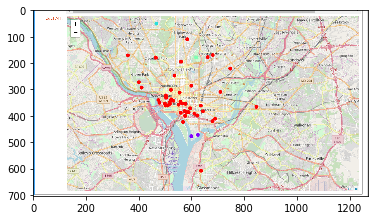

In [75]:
img=mpimg.imread('clusters2.png')
imgplot = plt.imshow(img)
plt.show()

# Because Github cannot show a map picture
# So I show the result using plt

In [76]:
dal_merged.loc[dal_merged['Cluster Labels'] == 0, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6213,20001,District of Columbia,0,Liquor Store,BBQ Joint,Yoga Studio,Dog Run,Café,Cocktail Bar,Coffee Shop,Convenience Store,Pizza Place
6214,20002,District of Columbia,0,Sandwich Place,Diner,Bus Line,New American Restaurant,Food & Drink Shop,Gym,Liquor Store,Bar,Moving Target
6215,20003,District of Columbia,0,Spa,Gym / Fitness Center,Mobile Phone Shop,Italian Restaurant,Sandwich Place,Chinese Restaurant,Bar,Bakery,Coffee Shop
6216,20004,District of Columbia,0,Hotel,Science Museum,Coffee Shop,Bakery,American Restaurant,Sandwich Place,Plaza,Exhibit,Steakhouse
6217,20005,District of Columbia,0,Hotel Bar,Coffee Shop,American Restaurant,Food Truck,Salon / Barbershop,Latin American Restaurant,Deli / Bodega,Sandwich Place,Sushi Restaurant
6218,20006,District of Columbia,0,Sandwich Place,Hotel,Café,American Restaurant,History Museum,Park,Bakery,Mexican Restaurant,Indian Restaurant
6219,20007,District of Columbia,0,Fast Food Restaurant,Bus Station,Park,Dog Run,Bagel Shop,Food Truck,Food & Drink Shop,Food Court,Fountain
6220,20008,District of Columbia,0,Mexican Restaurant,Italian Restaurant,Mediterranean Restaurant,Supplement Shop,Steakhouse,Sports Bar,Gift Shop,Liquor Store,Café
6221,20009,District of Columbia,0,Pizza Place,Cosmetics Shop,Jazz Club,Restaurant,Taco Place,Diner,Ethiopian Restaurant,Bakery,Latin American Restaurant
6222,20010,District of Columbia,0,Vietnamese Restaurant,Bakery,Pizza Place,Asian Restaurant,Yoga Studio,Caribbean Restaurant,Breakfast Spot,Mediterranean Restaurant,Soccer Field


In [77]:
dal_merged.loc[dal_merged['Cluster Labels'] == 1, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6295,20319,District of Columbia,1,Boat or Ferry,Filipino Restaurant,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Food Truck
6311,20593,District of Columbia,1,River,Sporting Goods Shop,Brewery,Heliport,Gay Bar,Boat or Ferry,Pizza Place,Soccer Stadium,Indian Restaurant


In [78]:
dal_merged.loc[dal_merged['Cluster Labels'] == 2, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6224,20012,District of Columbia,2,Dive Bar,Bus Station,Gym,Fast Food Restaurant,Yoga Studio,Fountain,Food Court,Food Truck,Fried Chicken Joint


In [79]:
dal_merged.loc[dal_merged['Cluster Labels'] == 3, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6225,20015,District of Columbia,3,Farmers Market,Yoga Studio,Filipino Restaurant,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain


In [80]:
dal_merged.loc[dal_merged['Cluster Labels'] == 4, dal_merged.columns[list(range(0,1)) + [6,7] + list(range(9, dal_merged.shape[1]))]]

,zip,county_name,Cluster Labels,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6294,20317,District of Columbia,4,Deli / Bodega,Golf Course,Gastropub,Gas Station,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant
